<a href="https://colab.research.google.com/github/MichelleAppel/Importance_sampling/blob/master/toy_examples/Toy_example_estimation_of_Radon-Nikodym_derivative_MNIST_one_sided.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy example estimation of Radon-Nikodym derivative for MNIST dataset (one sided)

Equation (5) of the paper by Binkowski et al. explains that the Radon-Nikodym derivative $\frac{d \mathbb{Q}_y}{ \mathbb{P}_y^G}$ of the two domains exist under the assumptions they state. This derivative can also be seen as the ratio between the two distributions of the domains, and can be used to express the compensation for imbalance in the domains:

$\mathbb{E}_{Y \sim \mathbb{Q}_y}[D(Y)] = \mathbb{E}_{X \sim \mathbb{P}_x}[D(G(X)) \frac{d \mathbb{Q}_y}{ d\mathbb{P}_y^G}(G(X))]$

This expresses compensation for imbalance between the discriminator outputs, caused by the imbalance in the domain distributions. However, it does not necessarily have to be used for the imbalance in the discriminator outputs. It can be applied to any imbalance caused by the different domain distributions.

--

In other words, we are trying to study the situation where we don't deal with a discriminator but with any function, let it be $f$. This $f$ can be any function, e.g. identity, mean.... We try to compensate for imbalances in the two domains over which we compute the function:

$\mathbb{E}_{Y \sim \mathbb{Q}_y}[f(Y)] = \mathbb{E}_{X \sim \mathbb{P}_x}[f(G(X)) \frac{d \mathbb{Q}_y}{ d\mathbb{P}_y^G}(G(X))]$

Possible functions $f$ for MNIST:
* use the label
* pre-trained classifier


--

This toy example uses a simplified version of MNIST.

The dataset only has zeroes and ones, and the percentage of zeros/ones is specified by the user

--

The following toy example shows how we can use the Radon-Nikodym derivative for compensating the imbalance for the mean of the domains using $\bar{Y} = \bar{X}\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}$.


Let $X = [1, 1, 1, 1, 1, 1, 1, 0, 0]$, with mean $\bar{X} = 0.8$ and <br />
Let $Y = [1, 1, 0, 0, 0, 0, 0, 0, 0]$, with mean $\bar{Y} = 0.2$

Then $[1, 1, 0, 0, 0, 0, 0, 0, 0] = [1, 1, 1, 1, 1, 1, 1, 0, 0] \cdot \frac{d \mathbb{Q}_y}{d \mathbb{P}_x}(X)$, and <br />
$\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}(X) = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 4, 4]$

This can be interpreted as the ratio between means of the domains for each of the samples. In this example the ratio can be calculated. However, in more complex situations, for example with images, the Radon-Nykodym derivative $\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}$ is unknown and we may try to estimate it using a neural network $W$. This leads to the objective function

$\inf_{W \in \mathcal{W}} (\mathbb{E}_{X \sim \mathbb{P}_x} [D(G(X)) \cdot W(X)] - \mathbb{E}_{Y \sim \mathbb{Q}_y}[D(Y)])^2$

used by Binkowski et al. for compensation of distributions in the domains, using the discriminator output. Similarly, we can use such a network in our toy example.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision
import numpy as np

import itertools

import matplotlib.pyplot as plt

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch.unsqueeze(1).unsqueeze(1).cpu(), nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0.5)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
'''def binary_data(size=(2**21, 1), ratio=0.5):
    
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio

    print(idx)
    print(idx.shape)
    image_batch = torch.zeros(size)
    image_batch[idx] = 1
    
    return image_batch.clamp(0, 1).cuda().detach()'''


'def binary_data(size=(2**21, 1), ratio=0.5):\n    \n    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio\n\n    print(idx)\n    print(idx.shape)\n    image_batch = torch.zeros(size)\n    image_batch[idx] = 1\n    \n    return image_batch.clamp(0, 1).cuda().detach()'

In [4]:
'''class ColorDataset(Dataset):
    ''The dataloader for the binary data
    '
    def __init__(self, ratio=0.5):

        self.ratio = ratio
        
        self.dataset = binary_data(ratio=self.ratio)
        
        self.example_imgs = self.example()
        
    def example(self):
        '
        Returns an example from each mode in the domain
        
        ''
        example_imgs = torch.zeros(size=(2, 1))
        example_imgs[1] = 1
        
        return example_imgs

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]'''

"class ColorDataset(Dataset):\n    ''The dataloader for the binary data\n    '\n    def __init__(self, ratio=0.5):\n\n        self.ratio = ratio\n        \n        self.dataset = binary_data(ratio=self.ratio)\n        \n        self.example_imgs = self.example()\n        \n    def example(self):\n        '\n        Returns an example from each mode in the domain\n        \n        ''\n        example_imgs = torch.zeros(size=(2, 1))\n        example_imgs[1] = 1\n        \n        return example_imgs\n\n    def __len__(self):\n        return len(self.dataset)\n    \n    def __getitem__(self, idx):      \n        return self.dataset[idx]"

In [5]:
def visualize_MNIST_img_batch(batch):
    '''Visualizes image batch for MNIST
    
    Parameters:
    batch (Tensor): An image batch
    '''
    fig = plt.figure()
    for i in range(batch.shape[0]):
      plt.subplot(1,2,i+1)
      plt.tight_layout()
      plt.imshow(batch[i], cmap='gray', interpolation='none')
      plt.title("Ground Truth: {}".format(i))
      plt.xticks([])
      plt.yticks([])

In [6]:
def MNIST_binary_data(ratio=0.5):
    # ratio: percentage of zeroes
    #returns (data, labels) for MNIST with only zeroes and ones, with the given ratio

    MNIST = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
    
    idxm0 = MNIST.train_labels==0
    idxm1 = MNIST.train_labels==1 
    dim = len(idxm0)  

    n0 = torch.sum(idxm0)
    n1 = torch.sum(idxm1)
    tot = n0 + n1

    if ratio < n0.item()/tot.item():
      if ratio == 1:
        size = n0
      else:
        size = int(n1/(1-ratio))
      idx0 = np.where(idxm0)[0]
      idx0 = idx0[:int(size*ratio)]
      idx1 = np.where(idxm1)[0]
      #idx0 = [True if i in indices else False for i in range(len(idx0))]
    else:
      if ratio == 1:
        size = n1
      else:
        size = int(n0/ratio)
      idx0 = np.where(idxm0)[0]
      idx1 = np.where(idxm1)[0]
      idx1 = idx1[:int(size*(1-ratio))]
      #idx1 = [True if i in indices else False for i in range(len(idx1))]

    idx = idx0.tolist() + idx1.tolist()
    idxm = torch.tensor( [True if i in idx else False for i in range(dim)] )

    #labels = MNIST.train_labels[idxm]
    #data = MNIST.train_data[idxm]

    MNIST.targets = MNIST.train_labels[idx]
    MNIST.data = MNIST.train_data[idx]

    return MNIST 

'''# TEST
res = MNIST_binary_data(0.2)
#print(res)
#print(res.targets) #labels
#print(res.data) #data

ones = res.targets.sum().item()
tot = res.targets.shape[0]
print('zeroes =' + str(tot-ones))
print('ones =' + str(ones))
print('ratio =' + str((tot-ones)/tot))'''

"# TEST\nres = MNIST_binary_data(0.2)\n#print(res)\n#print(res.targets) #labels\n#print(res.data) #data\n\nones = res.targets.sum().item()\ntot = res.targets.shape[0]\nprint('zeroes =' + str(tot-ones))\nprint('ones =' + str(ones))\nprint('ratio =' + str((tot-ones)/tot))"

In [7]:
class MNISTDataset(Dataset):
    '''The dataset for the MNIST binary data
    '''
    def __init__(self, ratio=0.5):

        self.ratio = ratio
        
        self.dataset = MNIST_binary_data(ratio=self.ratio)
        
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each digit in the domain
        
        '''
        labels = self.dataset.targets
        data = self.dataset.data
        img0 = data[labels==0][0].unsqueeze(0)
        img1 = data[labels==1][0].unsqueeze(0)
        ex = torch.cat((img0, img1), 0)
              
        return ex

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

'''# TEST
dataset = MNISTDataset()

fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.tight_layout()
  plt.imshow(dataset.example_imgs[i].cpu(), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(i))
  plt.xticks([])
  plt.yticks([])'''

'# TEST\ndataset = MNISTDataset()\n\nfig = plt.figure()\nfor i in range(2):\n  plt.subplot(1,2,i+1)\n  plt.tight_layout()\n  plt.imshow(dataset.example_imgs[i].cpu(), cmap=\'gray\', interpolation=\'none\')\n  plt.title("Ground Truth: {}".format(i))\n  plt.xticks([])\n  plt.yticks([])'

/home/michelle/.local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/michelle/.local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


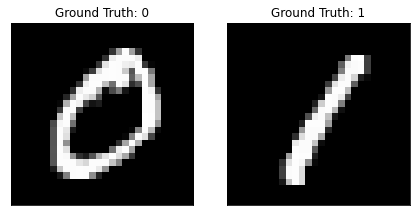

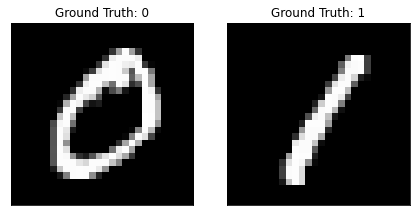

In [8]:
# Settings for domain A (red)
ratio_A = 0.2
dataset_A = MNISTDataset(ratio=ratio_A)
dataloader_A = DataLoader(dataset_A, batch_size=256, shuffle=True)

# Settings for domain B (green)
ratio_B = 0.8
dataset_B = MNISTDataset(ratio=ratio_B)
dataloader_B = DataLoader(dataset_B, batch_size=256, shuffle=True)

visualize_MNIST_img_batch(dataset_A.example_imgs.cpu())
visualize_MNIST_img_batch(dataset_B.example_imgs.cpu())

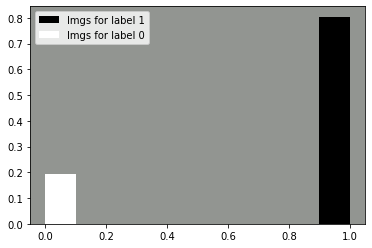

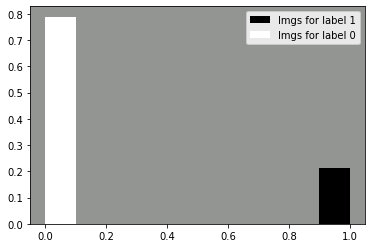

/home/michelle/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


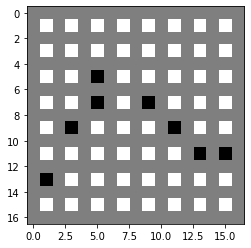

/home/michelle/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


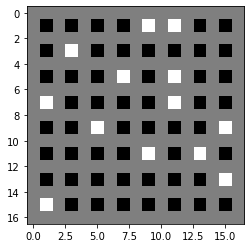

In [9]:
import cv2

def plot_hist(data):
    data = data.squeeze().cpu()
    plt.hist(data[data==1], weights=torch.ones(len(data[data==1]))/len(data), 
             color='black', bins=10, range= (0, 1))
    plt.hist(data[data==0], weights=torch.ones(len(data[data==0]))/len(data), 
             color='white', bins=10, range= (0, 1))
    plt.legend(['Imgs for label {}'.format(1), 
                'Imgs for label {}'.format(0)])
    plt.gca().set_facecolor('xkcd:gray')
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    labs_A = data_A[1].double()
    labs_B = data_B[1].double()

    plot_hist(labs_A)
    plot_hist(labs_B)
    
    visualize_img_batch(torch.tensor(labs_A[:64]).unsqueeze(1).cuda())
    visualize_img_batch(torch.tensor(labs_B[:64]).unsqueeze(1).cuda())
    break

In [11]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
#        self.fc1 = nn.Linear(1, 1)
#        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 40)
        self.fc2 = nn.Linear(40, 1)
        
    def forward(self, x):
        x = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        x = torch.sigmoid(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

#        h1 = torch.sigmoid(self.fc1(x))
#        out = self.fc2(h1)
#        return self.softmax(out)
#         return out

In [14]:
class IdentifyNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(IdentifyNet, self).__init__()
#        self.fc1 = nn.Linear(1, 1)
#        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 40)
        self.fc2 = nn.Linear(40, 1)
        
    def forward(self, x):
        x = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        x = torch.sigmoid(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

#        h1 = torch.sigmoid(self.fc1(x))
#        out = self.fc2(h1)
#        return self.softmax(out)
#         return out

In [59]:
# Initialize the networks
weight_network = WeightNet().cuda()
identify_net = IdentifyNet().cuda()

# Initialize the optimizers
lr = 0.01
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)
optimizer_i = optim.Adam(identify_net.parameters(), lr=lr)

losses_w = []

means_A = []
means_B = []

L_As = []
L_Bs = []

example_importances_A = []
example_importances_B = []

example_is = []

def weight_normalization(w):
    return w
#     return 0.5*(1 + w)

for epoch in range(20):
    for i, (batch_A, batch_B) in enumerate(zip(dataloader_A, dataloader_B)):
      
        real_A = batch_A[0].cuda().detach()
        real_B = batch_B[0].cuda().detach()
        labels_A = batch_A[1].cuda().detach()
        labels_B = batch_B[1].cuda().detach()
        
        # The weighting process
        w = weight_network(real_A)
        A = identify_net(real_A)
        B = identify_net(real_B)
    
        # The loss function --------------------------------------------------------------------------------
        
        # Using the means as objective function
        L_A  = (A.view(-1).detach() * weight_normalization(w).view(-1)).sum()
        L_B = (B.view(-1).detach()).mean()
        loss_w = (L_A - L_B)**2
        
        L_A_i  = (A.view(-1) * weight_normalization(w.detach()).view(-1)).sum()
        L_B_i = (B.view(-1)).mean()
        loss_i = -(L_A_i - L_B_i)**2        
        
        mean_A = (labels_A.view(-1).float() * w.view(-1)).sum()
        mean_B = (labels_B.view(-1).float()).mean()
        
        
        means_A += [mean_A]
        means_B += [mean_B]

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step() 
        
        optimizer_i.zero_grad()
        loss_i.backward()
        optimizer_i.step()         

        # Store values --------------------------------------------------------------------------------------
        L_As += [L_A.item()]
        L_Bs += [L_B.item()]
        
        losses_w += [loss_w.item()]
        
        w_a = weight_normalization((weight_network(dataset_A.example_imgs.float().unsqueeze(1).cuda())))
        example_importances_A += [(w_a[0].item(), w_a[1].item())] # Store examples in a list
        
        example_is += [identify_net(dataset_A.example_imgs.float().unsqueeze(1).cuda())]
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            print('epoch', epoch, 'step', i, 'loss_w: ', loss_w.item(), 'loss_i', loss_i.item())
            
        if i % 10000 == 0 and i != 0:
            break

epoch 0 step 0 loss_w:  5.292194487083179e-07 loss_i -5.292194487083179e-07
epoch 1 step 0 loss_w:  0.5033102035522461 loss_i -0.5033102035522461
epoch 2 step 0 loss_w:  49.563438415527344 loss_i -49.563438415527344
epoch 3 step 0 loss_w:  2.494140062481165e-06 loss_i -2.494140062481165e-06
epoch 4 step 0 loss_w:  9.874966053757817e-07 loss_i -9.874966053757817e-07
epoch 5 step 0 loss_w:  1.5943223843351007e-06 loss_i -1.5943223843351007e-06
epoch 6 step 0 loss_w:  1.3625831343233585e-06 loss_i -1.3625831343233585e-06
epoch 7 step 0 loss_w:  9.204413800034672e-07 loss_i -9.204413800034672e-07
epoch 8 step 0 loss_w:  9.351388143841177e-07 loss_i -9.351388143841177e-07
epoch 9 step 0 loss_w:  1.0027179087046534e-06 loss_i -1.0027179087046534e-06
epoch 10 step 0 loss_w:  1.3715034583583474e-06 loss_i -1.3715034583583474e-06
epoch 11 step 0 loss_w:  1.2706768757198006e-06 loss_i -1.2706768757198006e-06
epoch 12 step 0 loss_w:  1.0065414244309068e-06 loss_i -1.0065414244309068e-06
epoch 13 

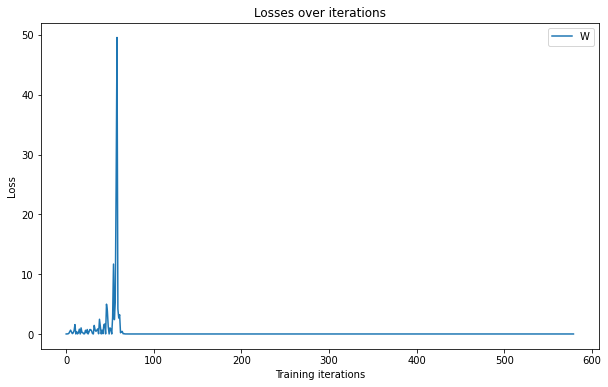

In [60]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_w)
plt.legend(['W'])
plt.show()

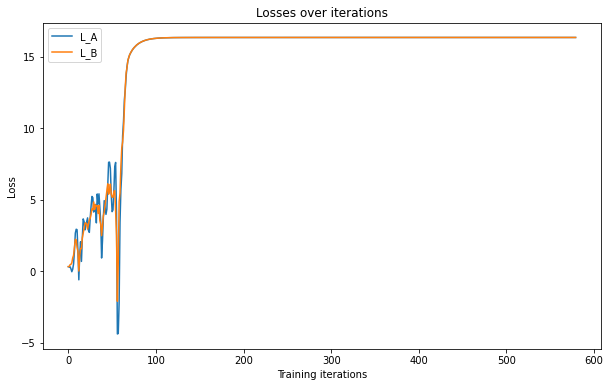

In [61]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(L_As)
plt.plot(L_Bs)
plt.legend(['L_A', 'L_B'])
plt.show()

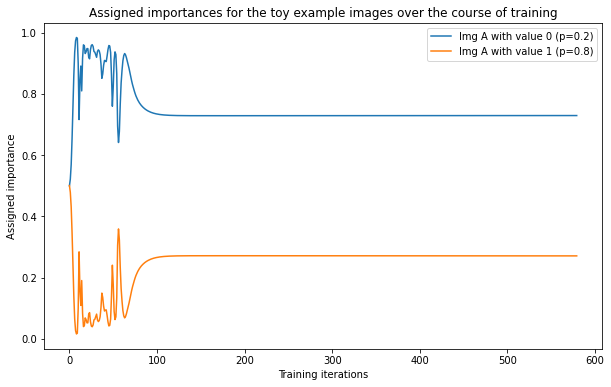

(0.7291747331619263, 0.27082523703575134)

In [62]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.legend(['Img A with value {} (p={})'.format(0, ratio_A), 
            'Img A with value {} (p={})'.format(1, 1-ratio_A)])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()

example_importances_A[-1]

ValueError: only one element tensors can be converted to Python scalars

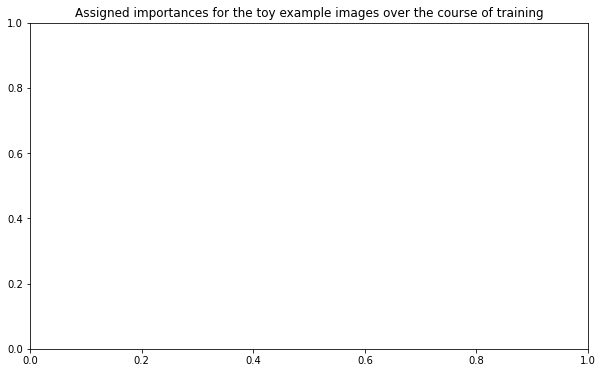

In [63]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_is)
plt.legend(['Img A with value {} (p={})'.format(0, ratio_A), 
            'Img A with value {} (p={})'.format(1, 1-ratio_A)])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()

example_importances_A[-1]

In [ ]:
# weights = weight_network(torch.linspace(0, 1, 64).view(-1,1).cuda()).cpu().detach().numpy()
# plt.figure(figsize=(10,6))
# plt.title('Assigned importances for image values')
# plt.plot(torch.linspace(0, 1, 64), weights)
# plt.ylabel('Assigned importance')
# plt.xlabel('Image value')
# plt.show()

In [ ]:
a = example_importances_A[-1][0]
b = example_importances_A[-1][1]
a, b

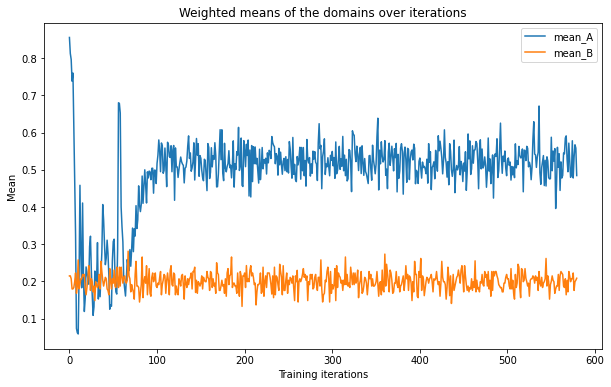

In [64]:
plt.figure(figsize=(10,6))
plt.title('Weighted means of the domains over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Mean')
plt.plot(means_A)
plt.plot(means_B)
plt.legend(['mean_A', 'mean_B'])
plt.show()